# Classification of Human vs LLM Generated Text Using BoW Perceptron

The following notebook implements a single perceptron BoW classifier to determine if text is generated by a human or a LLM.

First lets set up our environment. Import libraries, initalize recorders and seeds, etc.

In [4]:
# Standard ML libaries
import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm ## doesn't work in VSCode!!
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Custom utils for recording model progress.
from utils.recorder_util import ModelResults

In [5]:
# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

model_name = "feed_forward_bow"
author = "ben_secekeler"

results = ModelResults(model_name, author, seed)

device: cpu
random seed: 1234


Load the pre-split training/testing datasets using Pandas. 

In [6]:
train_data = pd.read_csv("../trainData/trainData.csv")
test_data = pd.read_csv("../testData/testData.csv")

train_data.head()

,label,source,text
0,0,1,Help wanted!\n\nThe Seagoing Cowboys program i...
1,0,1,The system of the Electoral College is a widel...
2,1,1,The renowned British statesman Winston Churchi...
3,0,1,"My grandfather would always say ""creativity is..."
4,1,1,In my pursuit to become an assistant manager a...


Use CountVectorizer to generate a BOW representation the inputs for testing/training data.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv.fit(train_data["text"])
vocab_size = len(cv.vocabulary_)

x_train_text = train_data["text"]
x_train = cv.transform(train_data["text"])
y_train = train_data["label"]

x_test_text = test_data["text"]
x_test = cv.transform(test_data["text"])
y_test = test_data["label"]

print(f"Loaded testing/training datasets. Vocab size of {vocab_size}.")

Loaded testing/training datasets. Vocab size of 68854.


In [8]:
from torch.utils.data import Dataset

class BotFinderDataset (Dataset):
	def __init__(self, x_text, x_bow, y_true):
		self.x_text = x_text
		self.x_bow = x_bow
		self.y = y_true

		# Convert the sparse numpy matrix into a pytorch sparse tensor (COO),
		sparse_x = x_bow.tocoo()
		i = torch.LongTensor(np.vstack((sparse_x.row, sparse_x.col)))
		v = torch.FloatTensor(sparse_x.data)
		self.x_bow_tensor = torch.sparse.FloatTensor(i, v, torch.Size(sparse_x.shape))

	def __len__(self):
		return len(self.y)
	
	def __getitem__(self, index):

		t = self.x_text[index]

		# Convert the sparse tensor into a dense array for X
		x = self.x_bow_tensor[index].to_dense()

		y = self.y[index]
		
		return (t, x, y)

Validate Dataset class by loading in random data from the training set.

In [9]:
dataset_testing = BotFinderDataset(x_train_text, x_train, y_train)
dataset_size = len(dataset_testing)

for _ in range(10):
	index = random.randrange(0, dataset_size)
	text, bow, y = dataset_testing[index]

	print(f"@{index}")
	print("\t" + " ".join(text.split()))
	print("\t" + str(bow))
	print(f"\tbow words: {sum(bow)}")
	print(f"\ttext words: {len(text.split())}")
	print("\tis bot: " + str(y))

/tmp/ipykernel_1064809/2959167272.py:13: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/torch/csrc/utils/tensor_new.cpp:651.)
  self.x_bow_tensor = torch.sparse.FloatTensor(i, v, torch.Size(sparse_x.shape))


@28883
	Wouldn't you like to be able to do your make up in the car without worrying about crashing? Or perhaps bring back a loved one that passed away due to crashing or a mobile accident? With the driveless cars i think that you could. Accidents are one of the greatest problems in not only america but in whole world. You wont be able to bring back a loved one that passed away butity will be more preventable now. I think that driveless cars will be a great idea. People die every day due to mobile accidents. For example i have an uncle that past away because he was in an accident. The whole family was destroyed, it shook our lifes up. With the driveless cars i feel like accidents will reduce by alot. The drivelss cars will be very helpful. For example not every morning you wake up on time, if your running late you could do your make up in the car while your on way to work or wherever you need to be. Also if you need to take a call or you need to text someone, you wont have to worry abou

Construct a basic perceptron model. 

In [ ]:
from torch import nn

class BinaryFFNModel(nn.Module):
	def __init__(self, dropout: float, layer_sizes: list):
		super().__init__()

		layers = []
		
		for i in range(len(layer_sizes) - 1):
			layers.append(nn.Dropout(dropout))
			layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
			layers.append(nn.ReLU())

		layers.append(nn.Dropout(dropout))
		layers.append(nn.Linear(layer_sizes[-1], 2))
		
		self.layers = nn.Sequential(*layers)
	
	def forward(self, x):
		return self.layers(x)

Initialize model instance, dataloaders, and hyper parameters for training.

In [29]:
from torch import optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

### HYPER PARAMETERS ###
dropout = 0.2
layers = [vocab_size, 100, 75, 50]
learning_rate = 1e-3
weight_decay = 1e-4
batch_size = 250
shuffle = True
n_epochs = 3

results.record_hyperparameter("dropout", dropout)
results.record_hyperparameter("layers", layers)
results.record_hyperparameter("learning_rate", learning_rate)
results.record_hyperparameter("weight_decay", weight_decay)
results.record_hyperparameter("batch_size", batch_size)
results.record_hyperparameter("shuffle", shuffle)
results.record_hyperparameter("n_epochs", n_epochs)
### HYPER PARAMETERS ###

model = BinaryFFNModel(dropout, layers).to(device=device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam (
	model.parameters(),
	lr = learning_rate,
	weight_decay = weight_decay
)

train_ds = BotFinderDataset(
	x_train_text,
	x_train,
	y_train
)
test_ds = BotFinderDataset(
	x_test_text,
	x_test,
	y_test
)

train_dl = DataLoader(train_ds, 
					  batch_size = batch_size, 
					  shuffle = shuffle, 
					  )
test_dl = DataLoader(test_ds, 
					  batch_size = batch_size, 
					  shuffle = shuffle)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=68854, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=100, out_features=75, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=75, out_features=50, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.2, inplace=False)
  (10): Linear(in_features=50, out_features=2, bias=True)
)


In [30]:
# training

results.record_training_start()

for epoch in range(n_epochs):
	print(f"epoch {epoch}")

	model.train()

	# for X, y_true in tqdm(train_dl):
	for _, X, y_true in train_dl:
		model.zero_grad()
		X = X.to(device)
		y_true = y_true.to(device)
		
		y_pred = model(X)

		loss = loss_function(y_pred, y_true)

		loss.backward()

		optimizer.step()

results.record_training_stop()

epoch 0
epoch 1
epoch 2


In [33]:
data_loader = test_dl
y_pred = []

model.eval()

# disable gradient calculation
with torch.no_grad():
    for _, X, _ in (data_loader):
        X = X.to(device)
        # predict one class per example
        y = torch.argmax(model(X), dim=1)
        # convert tensor to numpy array
        y_pred.append(y.cpu().numpy())
    
# print results
y_true = y_test
y_pred = np.concatenate(y_pred)

print(classification_report(y_true, y_pred, target_names=['human', 'bot'], digits = 3))

              precision    recall  f1-score   support

       human      0.504     0.510     0.507      3435
         bot      0.504     0.499     0.502      3435

    accuracy                          0.504      6870
   macro avg      0.504     0.504     0.504      6870
weighted avg      0.504     0.504     0.504      6870



In [34]:
results.record_performance(y_true, y_pred, ['human', 'bot'])

array([[0.51004367, 0.48995633],
       [0.50131004, 0.49868996]])

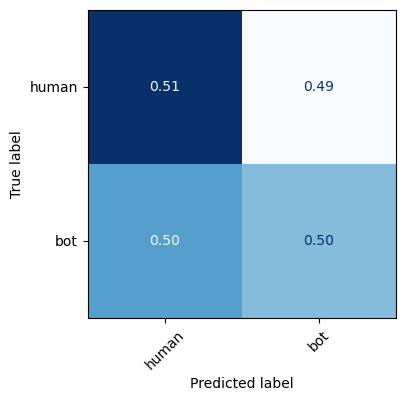

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['human', 'bot'])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(cmap='Blues', values_format='.2f', colorbar=False, ax=ax, xticks_rotation=45)
cm

Save results

In [20]:
results.write("feed_forward_bow")